# Movie recommendation on Amazon SageMaker with Neural Networks and MXNet

### Step SM1: Download ml-100k data  
***The data sets are needed to train our Neural Network. We use the 100,000 movie ratings given by users from MovieLens data sets. The dataset has be preprocessd using the Spark-preprocessing notebook.***

In [17]:
!pip install pydot

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray

import pandas as pd
import numpy as np


In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
s3_bucket = sess.default_bucket()
s3_prefix = 'movielens'

arn:aws:iam::349934754982:role/service-role/AmazonSageMaker-ExecutionRole-20190509T114602
CPU times: user 348 ms, sys: 23.5 ms, total: 372 ms
Wall time: 2.91 s


In [3]:
s3_bucket = sess.default_bucket()
s3_prefix = 'movielens'

### Data Information
*ua.base (train.csv): data for training*  
*ua.test (test.csv): data for test/validation*  
*Headers/columns :* ***user id | item id | rating (1-5) | timestamp | rating_b (0,1)***

In [4]:
import pandas as pd
import s3fs

train_df= pd.read_csv('train.csv',names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP','RATING_B'])
test_df= pd.read_csv('test.csv',names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP','RATING_B'])

In [5]:
pd.set_option('display.max_rows', 5)
train_df

,USER_ID,ITEM_ID,RATING,TIMESTAMP,RATING_B
0,1,2,3,876893171,0
1,1,3,4,878542960,1
...,...,...,...,...,...
90567,943,1228,3,888640275,0
90568,943,1330,3,888692465,0


In [7]:
def max_id(fname):
    mu = 0
    mi = 0
    k=0
    with open(fname) as f:
        for line in f:
            tks = line.strip().split(',')
            if k==0:
                k=k+1
            else:
                if len(tks) != 5:
                    continue
                mu = max(mu, int(tks[0]))
                mi = max(mi, int(tks[1]))
                k=k+1
    return mu + 1, mi + 1
max_users, max_items = max_id('train.csv')
(max_users, max_items)

(944, 1683)

### Setup training and test data and labels

In [11]:
X_train=train_df[['USER_ID','ITEM_ID']].values
y_train=train_df[['RATING']].values

In [8]:
X_test=test_df[['USER_ID','ITEM_ID']].values
y_test=test_df[['RATING']].values

### Upload data to S3 for later use for Sagemaker training jobs

In [9]:
!mkdir ./data ./data/train ./data/test

mkdir: cannot create directory ‘./data’: File exists
mkdir: cannot create directory ‘./data/train’: File exists
mkdir: cannot create directory ‘./data/test’: File exists


In [12]:
np.save('./data/train/train_X.npy', X_train)
np.save('./data/train/train_Y.npy', y_train)
np.save('./data/test/test_X.npy', X_test)
np.save('./data/test/test_Y.npy', y_test)

In [13]:
traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)
output_s3 = 's3://{}/{}/models/'.format(s3_bucket, s3_prefix)
code_location_s3 = 's3://{}/{}/codes'.format(s3_bucket, s3_prefix)

In [14]:
train_s3 = sess.upload_data(path='./data/train/', bucket=s3_bucket, key_prefix=traindata_s3_prefix)
test_s3 = sess.upload_data(path='./data/test/', bucket=s3_bucket, key_prefix=testdata_s3_prefix)

In [15]:
inputs = {'train':train_s3, 'test': test_s3}

### Build Keras model locally

In [16]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_latent_factors = 32

Using MXNet backend


In [17]:
def lin_net():
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(max_items, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(max_users, n_latent_factors,name='User-Embedding')(user_input))

    prod = keras.layers.dot([movie_vec, user_vec],axes=1,name='DotProduct')
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    return model

We visualize the architecture

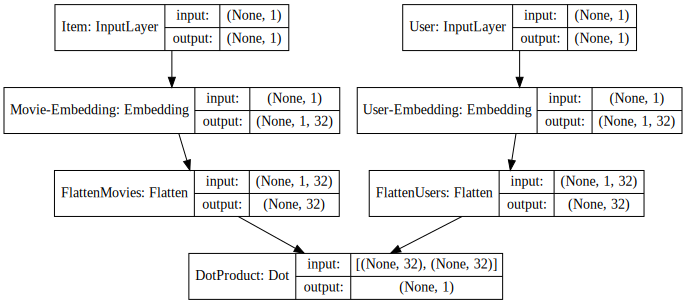

In [18]:
net=lin_net()
SVG(model_to_dot(net,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [19]:
model=lin_net()
model.summary()
model.fit([X_train[:,0], X_train[:,1]], y_train, epochs=10, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 32)        53856       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 32)        30208       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


90569/90569 [==============================] - 6s 72us/step - loss: 6.8465
Epoch 2/10
90569/90569 [==============================] - 7s 75us/step - loss: 1.1168
Epoch 3/10
90569/90569 [==============================] - 7s 74us/step - loss: 0.9397
Epoch 4/10
90569/90569 [==============================] - 7s 74us/step - loss: 0.9025
Epoch 5/10
90569/90569 [==============================] - 7s 75us/step - loss: 0.8777
Epoch 6/10
90569/90569 [==============================] - 7s 74us/step - loss: 0.8469
Epoch 7/10
90569/90569 [==============================] - 7s 75us/step - loss: 0.8083
Epoch 8/10
90569/90569 [==============================] - 7s 74us/step - loss: 0.7647
Epoch 9/10
90569/90569 [==============================] - 7s 74us/step - loss: 0.7199
Epoch 10/10
90569/90569 [==============================] - 7s 74us/step - loss: 0.6728


In [20]:
predictions = model.predict([X_test[:,0],X_test[:,1]])

In [21]:
predictions

array([[3.4796178],
       [3.9111855],
       [3.5571012],
       ...,
       [2.6331742],
       [2.8210623],
       [3.167014 ]], dtype=float32)

In [22]:
user_nb=3
movie_nb=45
model.predict([np.array([user_nb]),np.array([movie_nb])])

array([[3.77819]], dtype=float32)

In [29]:
movies_df=pd.read_csv('./ml-100k/u.item', sep='|', names=['item_id','title','release_date','video_release_date','imdb_url','UNKOWN','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Noir','Horror','Musical','Mystery','Romance','SciFi','Thriller','War','Western'],encoding='latin-1')
movies_df

,item_id,title,release_date,video_release_date,imdb_url,UNKOWN,Action,Adventure,Animation,Children,...,Fantasy,Noir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
movies={}
for index, row in movies_df.iterrows():
    movies[int(row['item_id'])]= row['title']

In [31]:
user_nb=3
score_threshold=2
maximum_recommendations=20

In [32]:
recommended_movies=[]
for movieId in range(max_items):
    result_score=model.predict([np.array([user_nb]),np.array([movieId])])
    if result_score > score_threshold:
        recommended_movies.append([int(movieId),result_score])

In [33]:
def getVal(item):
    return item[1]
recommended_movies=sorted(recommended_movies,key=getVal,reverse=True)

In [34]:
!pip install tabulate
import tabulate
from IPython.display import HTML, display

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
output_table = [['<strong>Movie Title</strong>','<strong>Score</strong>']]
for i in range(min(maximum_recommendations,len(recommended_movies))):
    output_table.append([movies[int(recommended_movies[i][0])],recommended_movies[i][1][0][0]])

display(HTML(tabulate.tabulate(output_table, tablefmt='html')))

Movie Title,Score
Pather Panchali (1955),4.568629264831543
Santa with Muscles (1996),4.428886413574219
Some Mother's Son (1996),4.280594825744629
Faust (1994),4.277665138244629
Anna (1996),4.201544284820557
Bitter Sugar (Azucar Amargo) (1996),4.199424743652344
Kaspar Hauser (1993),4.176368713378906
Maya Lin: A Strong Clear Vision (1994),4.1641011238098145
Legal Deceit (1997),4.163881301879883
"Saint of Fort Washington, The (1993)",4.140450477600098


## Deploy model on Sagemaker

In [36]:
from sagemaker.mxnet import MXNet, MXNetModel

In [37]:
mxnet_estimator = MXNet('keras_rec.py',
                        role=role,
                        train_instance_type='ml.c4.xlarge',
                        train_instance_count=1,
                        framework_version='1.3.0',
                        py_version='py3',
                        hyperparameters={'batch-size': 32,'epochs': 10,'learning-rate': 0.1,'embedding-size':32,'max-users':max_users,'max-items':max_items})
mxnet_estimator.fit(inputs)

2019-05-30 17:36:52 Starting - Starting the training job...
2019-05-30 17:36:56 Starting - Launching requested ML instances.........
2019-05-30 17:38:29 Starting - Preparing the instances for training......
2019-05-30 17:39:42 Downloading - Downloading input data
2019-05-30 17:39:42 Training - Training image download completed. Training in progress.
2019-05-30 17:39:43,455 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-05-30 17:39:43,457 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-05-30 17:39:43,471 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_INPUT_CONFIG_DIR': '/opt/ml/input/config', 'SM_CURRENT_HOST': 'algo-1', 'SM_CHANNELS': '["test","train"]', 'SM_HPS': '{"batch-size":32,"embedding-size":32,"epochs":10,"learning-rate":0.1,"max-items":1683,"max-users":944}', 'SM_OUTPUT_INTERMEDIATE_DIR': '/opt/ml/output/intermediate', 'SM_HP_EPOCHS': '10', 'SM_RESOURCE_CONFIG': '{"current

90569/90569 [==============================] - 6s 67us/step - loss: 6.9368
Epoch 2/10

90569/90569 [==============================] - 7s 73us/step - loss: 1.1203
Epoch 3/10

41664/90569 [============>.................] - ETA: 3s - loss: 0.9357


90569/90569 [==============================] - 7s 73us/step - loss: 0.9323
Epoch 4/10

87264/90569 [===========================>..] - ETA: 0s - loss: 0.8808


90569/90569 [==============================] - 7s 73us/step - loss: 0.8823
Epoch 5/10

90569/90569 [==============================] - 7s 73us/step - loss: 0.8436
Epoch 6/10

43392/90569 [=============>................] - ETA: 3s - loss: 0.8020


90569/90569 [==============================] - 7s 73us/step - loss: 0.8059
Epoch 7/10

88800/90569 [============================>.] - ETA: 0s - loss: 0.7688


90569/90569 [==============================] - 7s 73us/step - loss: 0.7692
Epoch 8/10

90569/90569 [==============================] - 7s 74us/step - loss: 0.7344
Epoch 9/10

44416/90569 [=============>................] - ETA: 3s - loss: 0.6917



2019-05-30 17:40:54 Uploading - Uploading generated training model45152/90569 [=============>................] - ETA: 3s - loss: 0.6910
90569/90569 [==============================] - 7s 73us/step - loss: 0.6969
Epoch 10/10

90569/90569 [==============================] - 7s 73us/step - loss: 0.6573
MXNet Backend: Successfully exported the model as MXNet model!
MXNet symbol file -  /opt/ml/model/model-symbol.json
MXNet params file -  /opt/ml/model/model-0000.params


Model input data_names and data_shapes are: 
data_names :  ['/User1', '/Item1']
data_shapes :  [DataDesc[/User1,(32, 1),float32,NCHW], DataDesc[/Item1,(32, 1),float32,NCHW]]


Note: In the above data_shapes, the first dimension represent the batch_size used for model training. 
You can change the batch_size for binding the module based on your inference batch_size.
2019-05-30 17:40:52,819 sagemaker-containers INFO     Reporting training SUCCESS



2019-05-30 17:40:59 Completed - Training job completed
Billable seconds: 96
